# n-Local Chain Network Optimization

This notebook uses gradient descent to reproduce the nonlocality results for the $n$-local chain network as described in ["Correlations in n-local scenario"](https://arxiv.org/abs/1411.4188).

[<img src="images/n-local_chain_network.png" width="800"/>](images/n-local_chain_network.png)

## Binary Inputs and Outputs

Consider classical inputs $x_i$ and $a_i \in \{0,1\}$ for all $i\in\{0,1,\dots,n+1\}$.
The $n$-local chain network correlation are then expressed

$$
P(a_1,\dots,a_{n+1}|x_1,\dots,x_{n+1}) = \text{Tr}\left[\Big(\bigotimes_{i=1}^{n+1}\Pi_{a_i}^{x_i}\Big)\Big(\bigotimes_{j=1}^n \Phi_j \Big)\right],
$$

where each $\Phi_j$ is a bipartite state shared between two measurement nodes and each $\Pi_{a_i}^{x_i}$ is a two-outcome, projective measurement.
Note that the measurements on the two end-nodes ($i=1$, $i=n+1$) are single qubit measurements while the interior nodes perform two-qubit measurements.
The n-local correlators are expressed as

$$
\langle A_1^{x_1},\dots,A_{n+1}^{x_{n+1}} \rangle = \sum_{a_1,\dots,a_{n+1}} (-1)^{\sum_{i=1}^{n+1}a_i}P(a_1,\dots,a_{n+1}|x_1,\dots,x_{n+1}).
$$

The $n$-local Bell inequality is expressed as

$$
\sqrt{|I|}+\sqrt{|J|} \leq 1,
$$

where

$$
I = \frac{1}{4} \sum_{x_1,x_{n+1}\in\{0,1\}}\langle A_1^{x_1},A_2^0,\dots,A_n^0,A_{n+1}^{x_{n+1}} \rangle,
$$

$$
J = \frac{1}{4} \sum_{x_1,x_{n+1}\in\{0,1\}}(-1)^{x_1 + x_{n+1}}\langle A_1^{x_1},A_2^1,\dots,A_n^1,A_{n+1}^{x_{n+1}} \rangle.
$$


## Setup

In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import time

## General $n$-Local `QNode` Construction

An $n$-local chain network contains $n$ Bell pairs and therefore requires $2n$ qubits.
The $n$-local correlator $\langle A_1^{x_1},\dots,A_{n+1}^{x_{n+1}} \rangle$ is computed by performing local qubit measurements in the $x$-$z$-plane.
Each measurement is prepared with a single qubit `RY` gate followed by a measurement in the computational basis.
Below we generalize the `QNode` construction for an arbitrary $n$-local chain network.

In [2]:
# function to construct a 2*n qubit device
nlocal_device = lambda n: qml.device("default.qubit", wires=2*n)

# apply measurement in computational basis to each wire
def nlocal_observable(n):
    obs = qml.PauliZ(wires=0)
    for i in range(1, 2*n):
        obs = obs @ qml.PauliZ(wires=i)

    return obs

def nlocal_chain_qnode(n):
    """
    Constructs a QNode that simulates an n-local chain network.
    
    Args:
        n (int) : Number of Bell pairs in the chain network.
    """
    dev = nlocal_device(n)
        
    @qml.qnode(dev)
    def circuit(settings):
        """
        Simulates the n-local chain network.
        Prepares `n` Bell states, performs local `RY` rotations on
        each qubit, and measures in the computational basis.
        
        Args:
            settings (array[float]) : `2*n` real values that specify
                                      the `RY` rotation on each qubit.
        """
        for i in range(n):
            a_id = 2 * i
            b_id = a_id + 1

            # bell state preparation
            qml.Hadamard(wires=a_id)
            qml.CNOT(wires=[a_id,b_id])

            # local rotation for measurement
            qml.RY(settings[a_id], wires=a_id)
            qml.RY(settings[b_id], wires=b_id)
        
        return qml.expval(nlocal_observable(n))

    return circuit

In [3]:
# Random settings for n-local chain network
def nlocal_chain_settings(n):
    return 2*np.pi*np.random.random((2*n,2)) - np.pi

## Cost Function: $n$-Local Bell Inequality

In [4]:
# The n-local Bell inequality serves as a cost function
def nlocal_chain_cost(nlocal_settings):
    nlocal_qnode = nlocal_chain_qnode(len(nlocal_settings)//2)
    
    I = _nlocal_I22(nlocal_qnode, nlocal_settings)
    J = _nlocal_J22(nlocal_qnode, nlocal_settings)
    
    return -1*(np.sqrt(abs(I)) + np.sqrt(abs(J)))
  
# helper to calculate I quantity
def _nlocal_I22(nlocal_qnode, nlocal_settings):
    (num_qubits, num_in) = nlocal_settings.shape 
    
    I22 = 0
    for x_start, x_end in [(0,0),(0,1),(1,0),(1,1)]:
        settings = []
        settings.append(nlocal_settings[0,x_start])
        settings.extend(nlocal_settings[1:(num_qubits - 1),0])
        settings.append(nlocal_settings[num_qubits - 1, x_end])
                
        I22 += nlocal_qnode(settings)
        
    return I22/4

# helper to calculate J quantity
def _nlocal_J22(nlocal_qnode, nlocal_settings):
    (num_qubits, num_in) = nlocal_settings.shape 
    
    J22 = 0
    for x_start, x_end in [(0,0),(0,1),(1,0),(1,1)]:
        settings = []
        settings.append(nlocal_settings[0,x_start])
        settings.extend(nlocal_settings[1:(num_qubits - 1),1])
        settings.append(nlocal_settings[num_qubits - 1, x_end])
                
        J22 += ((-1)**(x_start + x_end)) * nlocal_qnode(settings)
        
    return J22/4     

## Gradient Descent Optimization of Nonlocality

In [5]:
# optimization of n-local network nonlocality
def nlocal_gradient_descent(n, num_steps=150, step_size=0.1):
    opt = qml.GradientDescentOptimizer(stepsize=step_size)    
    nlocal_qnode = nlocal_chain_qnode(n)

    # initial settings
    settings = nlocal_chain_settings(n)
    scores = []
    samples = []

    # performing gradient descent
    for i in range(num_steps):
        settings = opt.step(nlocal_chain_cost, settings)
        
        if i%25 == 0:
            score = -(nlocal_chain_cost(settings))
            scores.append(score)
            samples.append(i)

            print("iteration : ",i, ", score : ", score)
            print("settings :\n", settings, "\n")
    
    final_score = -(nlocal_chain_cost(settings))
    
    scores.append(final_score)
    samples.append(num_steps-1)
    
    return (final_score, settings, scores, samples)

### Example: $(n = 3)$-Local Network

In [6]:
n3 = 3

n3_qnode = nlocal_chain_qnode(n3)
n3_qnode(np.zeros(2*n3))

tensor(1., requires_grad=True)

In [7]:
print(n3_qnode.draw())

 0: ──H──╭C──RY(0)──╭┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 1: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 2: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 3: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 4: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 5: ─────╰X──RY(0)──╰┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 



In [8]:
%%time

n3_score, n3_settings, n3_scores, samples = nlocal_gradient_descent(n3)

# printing final results    
print("final score : ", n3_score,",")
print("final settings : ", n3_settings,"\n")

iteration :  0 , score :  0.6630041492418528
settings :
 [[-1.17055995  0.36578614]
 [ 1.73028409 -1.89147459]
 [-1.68465518 -2.28561103]
 [-2.35651265  1.2510549 ]
 [ 1.97655551 -1.9287973 ]
 [-2.82224125 -1.8683572 ]] 

iteration :  25 , score :  1.2960110858251745
settings :
 [[-1.3607447   0.17184775]
 [ 2.21588901 -1.99295636]
 [-1.94349267 -2.14038674]
 [-2.09767516  1.10583061]
 [ 1.28193714 -1.26446723]
 [-3.02563551 -1.63467465]] 

iteration :  50 , score :  1.3957919336297877
settings :
 [[-1.39872105  0.1391198 ]
 [ 2.3986915  -2.10505456]
 [-2.00819257 -2.0976618 ]
 [-2.03297526  1.06310567]
 [ 0.99647135 -0.97177452]
 [-3.09057189 -1.57696519]] 

iteration :  75 , score :  1.4111927631997232
settings :
 [[-1.41086628  0.14314383]
 [ 2.46451018 -2.16275204]
 [-2.01863766 -2.08967165]
 [-2.02253017  1.05511552]
 [ 0.88213835 -0.85035296]
 [-3.11235943 -1.5622662 ]] 

iteration :  100 , score :  1.4137146620225707
settings :
 [[-1.41591707  0.14751736]
 [ 2.49009425 -2.187658

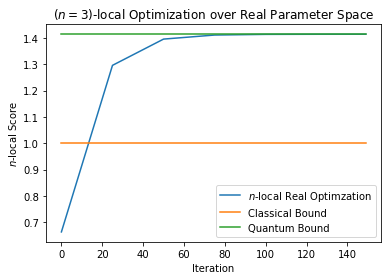

In [9]:
# Plot the score of the Bell inequality
plt.plot(samples, n3_scores, label = r"$n$-local Real Optimzation")
plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2*np.sqrt(1/2)]*len(samples), label = "Quantum Bound")
plt.title(r"$(n=3)$-local Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$n$-local Score")
plt.legend()
plt.show()

### Example: $(n=8)$-Local Network

In [10]:
n8 = 8

n8_qnode = nlocal_chain_qnode(n8)
n8_qnode(np.zeros(2*n8))

tensor(1., requires_grad=True)

When the settings are initialized to zero, the cost is expected to be $-1$, a saturation of the $n$-local Bell inequality.

In [11]:
nlocal_chain_cost(np.zeros((2*n8,2)))

tensor(-1., requires_grad=True)

In [12]:
print(n8_qnode.draw())

  0: ──H──╭C──RY(0)──╭┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  1: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  2: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  3: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  4: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  5: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  6: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  7: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  8: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  9: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 10: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 11: ─────╰X──RY(0)──

In [13]:
%%time

n8_score, n8_settings, n8_scores, samples = nlocal_gradient_descent(n8)

# printing final results    
print("final score : ", n8_score,",")
print("final settings : ", n8_settings,"\n")

iteration :  0 , score :  0.26645214387633565
settings :
 [[ 1.54913439  0.10583764]
 [ 1.84204872 -0.70545846]
 [ 2.24788714  2.94094885]
 [ 1.83039317 -2.85237344]
 [ 1.57766594 -0.9229682 ]
 [ 0.68894146  2.78119901]
 [ 1.76605293  2.06856834]
 [ 0.66869275 -1.92324527]
 [-3.11725312  1.48449494]
 [-1.91154971 -0.80571295]
 [-1.1784573  -2.42589173]
 [ 0.51198403  3.02389868]
 [-3.08220348  0.2718623 ]
 [ 0.34642707  0.99182982]
 [ 0.81471404  2.79623514]
 [-2.13825639 -1.27671235]] 

iteration :  25 , score :  1.1095357482930321
settings :
 [[ 1.80429962  0.12386128]
 [ 1.55280802 -0.68940663]
 [ 2.15385842  3.10812377]
 [ 1.92442189 -3.01954836]
 [ 1.35771467 -0.72985939]
 [ 0.90889273  2.5880902 ]
 [ 1.4768965   1.76777358]
 [ 0.95784918 -1.62245051]
 [-2.78759738  1.78574489]
 [-2.24120545 -1.1069629 ]
 [-1.61358234 -2.72012494]
 [ 0.94710907  3.31813189]
 [-3.01845635  0.52276995]
 [ 0.28267994  0.74092217]
 [ 0.96399415  2.85967758]
 [-2.54168214 -1.08600914]] 

iteration :  5

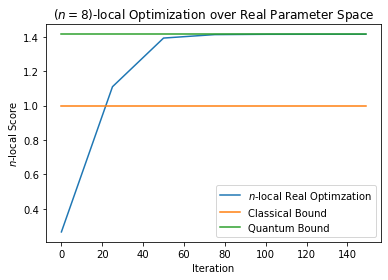

In [14]:
# Plot the score of the Bell inequality
plt.plot(samples, n8_scores, label = r"$n$-local Real Optimzation")
plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2*np.sqrt(1/2)]*len(samples), label = "Quantum Bound")
plt.title(r"$(n=8)$-local Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$n$-local Score")
plt.legend()
plt.show()